In [1]:
import torch
import random
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# 设置随机种子确保可重现性
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# 检查CUDA可用性并设置设备
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
if torch.cuda.is_available():
    print(f"GPU名称: {torch.cuda.get_device_name(0)}")
    print(f"GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# 设置默认数据类型
torch.set_default_dtype(torch.float32)

# 设置matplotlib字体为Arial
plt.rcParams['font.family'] = 'Arial'

使用设备: cuda:0
GPU名称: NVIDIA GeForce RTX 4070
GPU内存: 12.0 GB


In [2]:
# 读取数据
print("\n1. 读取数据...")
data = pd.read_csv("../data/water_CNN_with_AlphaEarth_all_merged.csv")
print(f"数据形状: {data.shape}")
print(f"数据列: {list(data.columns)}")

# 检查标签分布
landcover_counts = data['landcover'].value_counts()
print(f"\n原始标签分布:")
for label, count in landcover_counts.items():
    percentage = (count / len(data)) * 100
    print(f"  类别 {label}: {count} 个样本 ({percentage:.1f}%)")

# 将标签重新映射：0->0 (非水体), 11->1 (水体)
print("\n重新映射标签: 0->0 (非水体), 11->1 (水体)")
data['landcover_binary'] = data['landcover'].map({0: 0, 11: 1})

# 检查重新映射后的标签分布
binary_counts = data['landcover_binary'].value_counts()
print(f"\n重新映射后标签分布:")
for label, count in binary_counts.items():
    label_name = "非水体" if label == 0 else "水体"
    percentage = (count / len(data)) * 100
    print(f"  类别 {label} ({label_name}): {count} 个样本 ({percentage:.1f}%)")

# 数据划分：70%训练，30%验证
print("\n2. 数据划分...")
train_data = data[data['random'] <= 0.7]
val_data = data[data['random'] > 0.7]
print(f"训练集大小: {len(train_data)}")
print(f"验证集大小: {len(val_data)}")

# 特征列：包含AlphaEarth和Sentinel-2波段
feature_columns = ['A31', 'A36', 'A46', 'A47', 'A63', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
print(f"\n使用特征: {feature_columns}")
print(f"特征数量: {len(feature_columns)}")

# 处理训练数据
print("\n3. 处理训练数据...")
train_features_list = []
for col in feature_columns:
    col_data = np.array(train_data[col].apply(ast.literal_eval).values.tolist())
    train_features_list.append(col_data)

# 堆叠特征 (样本数, 特征数, 3, 3) - 注意这里改为3x3
train_features = np.stack(train_features_list, axis=1)
print(f"训练特征形状: {train_features.shape}")

# 数据是5x5窗口，保持原始尺寸
print(f"使用5x5窗口，训练特征形状: {train_features.shape}")

train_features = torch.tensor(train_features, dtype=torch.float32)
train_labels = torch.tensor(train_data['landcover_binary'].values, dtype=torch.long)

# 处理验证数据
print("\n4. 处理验证数据...")
val_features_list = []
for col in feature_columns:
    col_data = np.array(val_data[col].apply(ast.literal_eval).values.tolist())
    val_features_list.append(col_data)

val_features = np.stack(val_features_list, axis=1)
print(f"验证特征形状: {val_features.shape}")

# 验证数据也是5x5窗口
print(f"验证特征形状: {val_features.shape}")

val_features = torch.tensor(val_features, dtype=torch.float32)
val_labels = torch.tensor(val_data['landcover_binary'].values, dtype=torch.long)


1. 读取数据...
数据形状: (9899, 17)
数据列: ['A31', 'A36', 'A46', 'A47', 'A63', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'landcover', 'random']

原始标签分布:
  类别 0: 7484 个样本 (75.6%)
  类别 11: 2415 个样本 (24.4%)

重新映射标签: 0->0 (非水体), 11->1 (水体)

重新映射后标签分布:
  类别 0 (非水体): 7484 个样本 (75.6%)
  类别 1 (水体): 2415 个样本 (24.4%)

2. 数据划分...
训练集大小: 6954
验证集大小: 2945

使用特征: ['A31', 'A36', 'A46', 'A47', 'A63', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
特征数量: 15

3. 处理训练数据...
训练特征形状: (6954, 15, 5, 5)
使用5x5窗口，训练特征形状: (6954, 15, 5, 5)

4. 处理验证数据...
验证特征形状: (2945, 15, 5, 5)
验证特征形状: (2945, 15, 5, 5)


In [3]:
# 创建数据加载器
print("\n5. 创建数据加载器...")
train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"批次大小: {batch_size}")
print(f"训练批次数: {len(train_loader)}")
print(f"验证批次数: {len(val_loader)}")

# 定义CNN模型 - 适配5x5输入和15个特征通道，参考原始geeCNN架构
print("\n6. 定义CNN模型...")
class WaterCNN(nn.Module):
    def __init__(self, num_features=15, num_classes=2):
        super(WaterCNN, self).__init__()

        # 参考原始geeCNN架构，适配5x5窗口
        self.conv1 = nn.Conv2d(in_channels=num_features, out_channels=16, kernel_size=(3, 3), padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0)
        self.conv3 = nn.Conv2d(in_channels=32 + num_features, out_channels=64, kernel_size=(1, 1))  # 连接中心1x1
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 1))
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=(1, 1))

    def forward(self, x):
        # x shape: (batch, 15, 5, 5)
        x1 = F.relu(self.conv1(x))  # (batch, 16, 3, 3) - 5x5 -> 3x3
        x2 = F.relu(self.conv2(x1))  # (batch, 32, 1, 1) - 3x3 -> 1x1

        # 取原始输入的中心1x1区域
        center_1x1 = x[:, :, 2:3, 2:3]  # (batch, 15, 1, 1) - 从5x5中取中心

        # 连接特征
        x3_input = torch.cat((x2, center_1x1), dim=1)  # (batch, 32+15=47, 1, 1)
        x3 = F.relu(self.conv3(x3_input))  # (batch, 64, 1, 1)
        x4 = F.relu(self.conv4(x3))  # (batch, 128, 1, 1)
        x5 = self.conv5(x4)  # (batch, 2, 1, 1)

        # 展平为分类输出
        return x5.view(x5.size(0), -1)  # (batch, 2)

# 创建模型并移到GPU
model = WaterCNN(num_features=len(feature_columns), num_classes=2)
print(f"模型参数数量: {sum(p.numel() for p in model.parameters())}")

# 确保模型完全移动到设备
model = model.to(device)
print(f"模型已移动到设备: {device}")

# 检查模型参数设备
for name, param in model.named_parameters():
    if param.device != device:
        print(f"警告: 参数 {name} 在设备 {param.device}，应该在 {device}")

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
##optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print(f"损失函数: {criterion}")
print(f"优化器: {optimizer}")


5. 创建数据加载器...
批次大小: 8
训练批次数: 870
验证批次数: 369

6. 定义CNN模型...
模型参数数量: 18466
模型已移动到设备: cuda:0
损失函数: CrossEntropyLoss()
优化器: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [4]:
# 训练模型
print("\n7. 开始训练...")
num_epochs = 200
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
    
    # 验证阶段
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()
    
    # 计算平均损失和准确率
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_acc = 100 * train_correct / train_total
    val_acc = 100 * val_correct / val_total
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
    
    # 更新学习率
    scheduler.step()
    
    # 打印进度
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

print(f"\n训练完成！最佳验证准确率: {best_val_acc:.2f}%")


7. 开始训练...
Epoch [5/200]
  Train Loss: 0.4733, Train Acc: 75.83%
  Val Loss: 0.4728, Val Acc: 75.08%
  Learning Rate: 0.001000
Epoch [10/200]
  Train Loss: 0.2184, Train Acc: 95.59%
  Val Loss: 0.2168, Val Acc: 95.31%
  Learning Rate: 0.000500
Epoch [15/200]
  Train Loss: 0.1613, Train Acc: 96.16%
  Val Loss: 0.1737, Val Acc: 95.55%
  Learning Rate: 0.000500
Epoch [20/200]
  Train Loss: 0.1411, Train Acc: 96.20%
  Val Loss: 0.1553, Val Acc: 95.72%
  Learning Rate: 0.000250
Epoch [25/200]
  Train Loss: 0.1346, Train Acc: 96.25%
  Val Loss: 0.1500, Val Acc: 95.76%
  Learning Rate: 0.000250
Epoch [30/200]
  Train Loss: 0.1304, Train Acc: 96.25%
  Val Loss: 0.1454, Val Acc: 95.89%
  Learning Rate: 0.000125
Epoch [35/200]
  Train Loss: 0.1294, Train Acc: 96.25%
  Val Loss: 0.1439, Val Acc: 95.89%
  Learning Rate: 0.000125
Epoch [40/200]
  Train Loss: 0.1269, Train Acc: 96.26%
  Val Loss: 0.1422, Val Acc: 95.93%
  Learning Rate: 0.000063
Epoch [45/200]
  Train Loss: 0.1261, Train Acc: 96.28


8. 最终评估...
最终验证准确率: 0.9596

分类报告:
              precision    recall  f1-score   support

         非水体       0.96      0.98      0.97      2211
          水体       0.95      0.89      0.92       734

    accuracy                           0.96      2945
   macro avg       0.96      0.94      0.94      2945
weighted avg       0.96      0.96      0.96      2945


模型已保存到: model/water_cnn_alpha_model.pth

9. 绘制训练曲线...


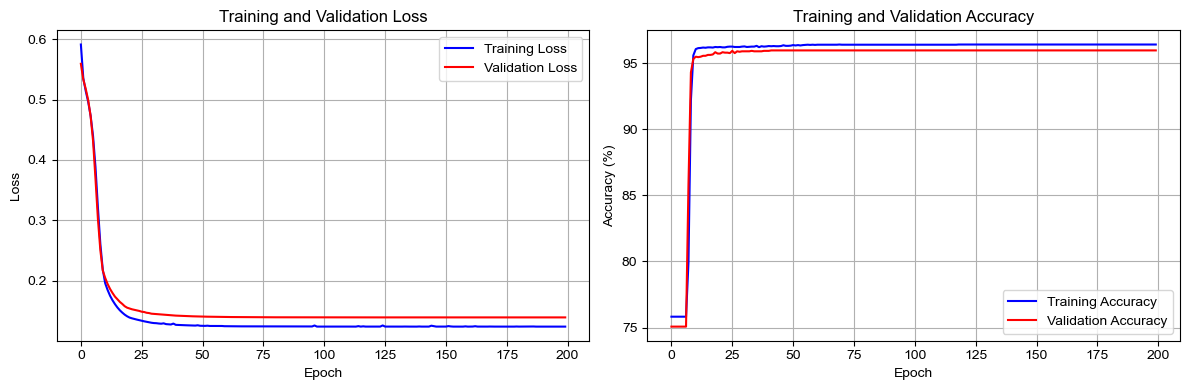


10. 绘制混淆矩阵...


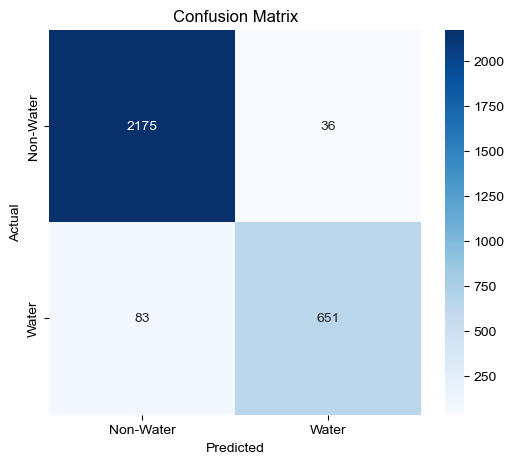


🎉 CNN模型训练完成！
最终验证准确率: 0.9596
模型文件: model/water_cnn_alpha_model.pth
训练曲线: model/training_curves.png
混淆矩阵: model/confusion_matrix.png


In [5]:
# 加载最佳模型进行最终评估
model.load_state_dict(best_model_state)

# 最终评估
print("\n8. 最终评估...")
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# 计算评估指标
final_accuracy = accuracy_score(all_targets, all_predictions)
print(f"最终验证准确率: {final_accuracy:.4f}")

print("\n分类报告:")
print(classification_report(all_targets, all_predictions, 
                          target_names=['非水体', '水体']))

# 保存模型
model_path = "model/water_cnn_alpha_model.pth"
import os
os.makedirs("model", exist_ok=True)
torch.save(best_model_state, model_path)
print(f"\n模型已保存到: {model_path}")

# 绘制训练曲线
print("\n9. 绘制训练曲线...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 损失曲线
ax1.plot(train_losses, label='Training Loss', color='blue')
ax1.plot(val_losses, label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# 准确率曲线
ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('model/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# 绘制混淆矩阵
print("\n10. 绘制混淆矩阵...")
cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Water', 'Water'],
            yticklabels=['Non-Water', 'Water'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('model/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🎉 CNN模型训练完成！")
print(f"最终验证准确率: {final_accuracy:.4f}")
print(f"模型文件: {model_path}")
print("训练曲线: model/training_curves.png")
print("混淆矩阵: model/confusion_matrix.png")

In [6]:
path_trained_model = 'model/water_cnn_alpha_model.pth'
model = WaterCNN()
model.load_state_dict(torch.load(path_trained_model))
model.eval()

weights_and_biases = {}

for layer_name, params in model.named_parameters():
    weights_and_biases[layer_name] = params.detach().numpy().tolist()

In [7]:
weights_and_biases.keys()

dict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias'])

In [ ]:
print(weights_and_biases['conv5.weight'])

[[[[0.029604211449623108]], [[0.055915214121341705]], [[0.07540883868932724]], [[-0.050294097512960434]], [[-0.11346714198589325]], [[0.09506802260875702]], [[0.027703644707798958]], [[0.06720340996980667]], [[0.2155243456363678]], [[-0.15974555909633636]], [[0.02615516260266304]], [[0.1160387322306633]], [[0.06144069880247116]], [[-0.1481848657131195]], [[-0.06899847835302353]], [[-0.04332266375422478]], [[-0.1331150084733963]], [[-0.020399635657668114]], [[-0.08456649631261826]], [[0.03644039109349251]], [[0.08861946314573288]], [[0.1665755808353424]], [[0.047320954501628876]], [[-0.08703121542930603]], [[-0.015231185592710972]], [[0.14160360395908356]], [[0.04610791057348251]], [[0.05954702943563461]], [[-0.07641586661338806]], [[0.17005132138729095]], [[0.03732772916555405]], [[-0.06207260116934776]], [[0.08880298584699631]], [[0.05665929242968559]], [[0.06068494915962219]], [[0.017160475254058838]], [[-0.03437579423189163]], [[-0.03098398633301258]], [[-0.03157244995236397]], [[0.